Pricing worst off options - creating a class for this 

In [ ]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np

In [ ]:
class WorstOf():
    def __init__(self, type, spots, vols, corr_matrices, r, T, strike, num_of_simulations = 100000):
        self.type = type
        self.spots = spots
        self.vols = vols
        self.corr_matrices = corr_matrices
        self.r = r
        self.T = T
        self.strike = strike
        self.num_of_simulations = num_of_simulations



    def simulateGeoPaths(self):
        """
        Simulation of multiple underlying assets under the 
        risk-neutral measure using a single-step Monte Carlo.
        """

        n_assets = len(self.spots)
        L = np.linalg.cholesky(self.corr_matrices)        # Cholesky decomposition of the correlation matrix
        Z = np.random.normal(0.0, 1.0, (self.num_of_simulations, n_assets))
        correlated_Z = np.dot(Z, L.T)
        #correlated_Z = Z @ L
        single_step_terminal_price = np.zeros_like(correlated_Z)

        for i in range(n_assets):
            drift = (self.r - 0.5 * self.vols[i]**2) * self.T
            diffusion = self.vols[i] * np.sqrt(self.T) * correlated_Z[:, i]
            single_step_terminal_price[:, i] = self.spots[i] * np.exp(drift + diffusion)
        return single_step_terminal_price
    
    def price(self):
        """
        Price the worst of option using the simulated price paths.
        """
        
        price_Paths = self.simulateGeoPaths()
        percentage_performance = price_Paths / self.spots
        worst_performer_index = np.argmin(percentage_performance, axis=1)
        worst_performer_dollar = np.array([percentage_performance[i, idx] * self.spots[idx] for i, idx in enumerate(worst_performer_index)])
        if self.type == 'Call':
            payoff = np.maximum(0.0, worst_performer_dollar - self.strike*self.spots[worst_performer_index])
        elif self.type == 'Put':
            payoff = np.maximum(0.0, self.strike*self.spots[worst_performer_index] - worst_performer_dollar)
        
        discount_payoff = payoff * np.exp(-self.r * self.T)
        return np.mean(discount_payoff)


# Pricing Up and In European Barrier Option

In [ ]:
import numpy as np
import matplotlib.pyplot as plt





def simulate_gbm(s_0, mu, sigma, T, N, n_sims=1000, random_seed=1):
    """Simulate stock returns using Geometric Brownian Motion."""
    
    np.random.seed(random_seed)

    dt = T / N #N time steps

    # scale is the standard deviation of the distribution
    # size is how big the output will be: n_sim rows and N columns
    dW = np.random.normal(scale=np.sqrt(dt), size=(n_sims, N + 1))

    # simulate the evolution of the process
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma**2) * dt + sigma * dW, axis=1))
    S_t[:, 0] = s_0 #corrects the first column value

    return S_t




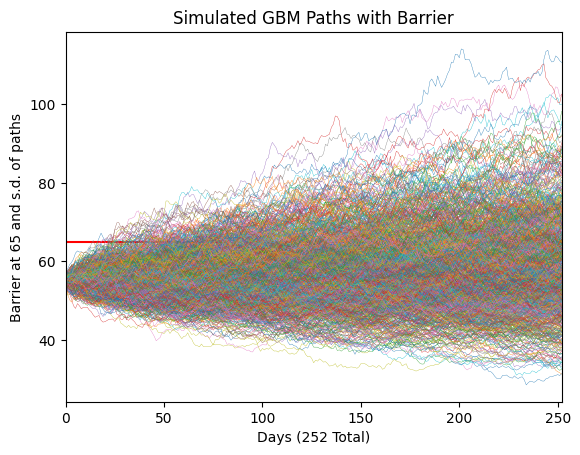

In [8]:
S_0 = 55
r = 0.06
sigma = 0.2
T = 1 # 1year
N = 252 #no of trad. days

BARRIER = 65
K = 60

gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, T=T, N=N)


plt.title('Simulated GBM Paths with Barrier')
plt.axhline(y=BARRIER, color='r', linestyle='-')
plt.xlim(0, N)
plt.plot(gbm_sims.T, linewidth=0.25)
plt.ylabel('Barrier at 65 and s.d. of paths')
plt.xlabel('Days (252 Total)')
plt.show()



In [14]:
max_value_per_path = np.max(gbm_sims, axis=1)
# returns a 1-D array whose length equals the number of simulated paths.
# Element i of that array is the highest price that path i ever reached over the whole life of the simulation. In symbols,

payoff = np.where(
    max_value_per_path > BARRIER, 
    np.maximum(0, gbm_sims[:, -1] - K), 
    0
)

print(payoff[0:5])

[9.78690242 3.47146872 0.81002874 2.11320171 7.68252745]


In [16]:
discount_factor = np.exp(-r * T)
premium = discount_factor * np.mean(payoff)
print(premium)

4.019441670553388
